<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Import-Necessary-Packages" data-toc-modified-id="Import-Necessary-Packages-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Import Necessary Packages</a></span></li><li><span><a href="#Collect-Data-Set-From-the-MAST-Archive-Using-Astroquery" data-toc-modified-id="Collect-Data-Set-From-the-MAST-Archive-Using-Astroquery-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Collect Data Set From the MAST Archive Using Astroquery</a></span></li></ul></li><li><span><a href="#Default-Dark-File" data-toc-modified-id="Default-Dark-File-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Default Dark File</a></span></li><li><span><a href="#Make-Basedark" data-toc-modified-id="Make-Basedark-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Make Basedark</a></span></li><li><span><a href="#Make-Weekdark" data-toc-modified-id="Make-Weekdark-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Make Weekdark</a></span></li><li><span><a href="#Calibrate-with-New-Weekdark" data-toc-modified-id="Calibrate-with-New-Weekdark-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calibrate with New Weekdark</a></span><ul class="toc-item"><li><span><a href="#Calibration" data-toc-modified-id="Calibration-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Calibration</a></span></li><li><span><a href="#Comparison-With-the-Default-Dark-File" data-toc-modified-id="Comparison-With-the-Default-Dark-File-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Comparison With the Default Dark File</a></span></li></ul></li></ul></div>

## Introduction
In the Calstis pipline for calibrating STIS CCD data, one of the step is dark signal substraction, which removes the dark signal (count rate created in the detector in the absence of photons from the sky) from the uncalibrated science image based on reference file. Usually, the Calstis pipline uses the default dark reference file specified in the 0-extension header of the uncalibrated science image fits file. But for some sources, it is necessary to customize the dark reference for the observations. In this notebook, we will go through how to create dark reference files using the Python refstis library.

### Import Necessary Packages
- `astropy.io fits` `astropy.table` for accessing FITS files
- `astroquery.mast Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `os`,`shutil`,`pathlib` for managing system paths
- `numpy` to handle array functions
- `stistools` for calibrating STIS data
- `refstis` for creating STIS reference files
- `matplotlib` for plotting data

In [1]:
# Import for: Reading in fits file
from astropy.io import fits
from astropy.table import Table

# Import for: Downloading necessary files. (Not necessary if you choose to collect data from MAST)
from astroquery.mast import Observations

# Import for: Managing system variables and paths
import os,shutil
from pathlib import Path

# Import for: Quick Calculation and Data Analysis
import numpy as np

# Import for: Operations on STIS Data
import stistools
from refstis.basedark import make_basedark
from refstis.weekdark import make_weekdark

# Import for: Plotting and specifying plotting parameters
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.cmap'] = 'plasma'
matplotlib.rcParams['image.interpolation'] = 'none'
matplotlib.rcParams['figure.figsize'] = (20,10)

/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


### Collect Data Set From the MAST Archive Using Astroquery
There are other ways to download data from MAST such as using CyberDuck. The steps of collecting data is beyond the scope of this notebook, and we are only showing how to use astroquery.

In [2]:
# change this field in you have a specific dataset to be explored
obs_id="oeax05040"
# Search target objscy by obs_id
target = Observations.query_criteria(obs_id=obs_id)
# get a list of files assiciated with that target
FUV_list = Observations.get_product_list(target)
# Download fits files
result = Observations.download_products(FUV_list,extension='fits')
crj = os.path.join("./mastDownload/HST","{}".format(obs_id),"{}_crj.fits".format(obs_id))

## Default Dark File
The default dark file is specified in the 0th extension of an uncalibrated science image through a field called 'DARKFILE'. We will later replace this default dark file with the customized dark file we created using refstis.

In [3]:
darkfile = fits.getheader(crj,0)['DARKFILE']
print("The default dark file of observation {id} is: {df}".format(id=obs_id,df=darkfile))

The default dark file of observation oeax05040 is: oref$5491744go_drk.fits


## Make Basedark
Every month, a high signal-to-noise superdark frame is created from a combination of typically 40-60 “long” darks. These monthly superdark frames are not actually delivered to the calibration data base, but used as “baseline” dark for the next steps. In this section, we'll show how to create the basedark file.

These superdark frames are not taken exactly each month, but during a roughly 30 days period called "annealing period". The duration of each annealing period, together with the superdark frames taken, can be found here: [STIS Annealing Periods](https://www.stsci.edu/~STIS/monitors/anneals/anneal_periods.html).

We first get the observation date of our sample data, and find the corresponding anneal period:

In [4]:
TDATEOBS = fits.getheader(crj,0)["TDATEOBS"]
print("UT date of start of first exposure in file is {}".format(TDATEOBS))

UT date of start of first exposure in file is 2021-03-13


According to the STIS Annealing Periods, this observation was taken during the annealing period from 2021-03-12 02:18:15 to 2021-04-07 02:35:41. We collect all the superdark frames flt data during that annealing period:

In [5]:
# copy the dark file obs_id from the STIS Annealing Periods table, and put them into a list
rootnames = 'oeep3tbqq, oeep3ucgq, oeep3vctq, oeep3wd1q, oeep3xi5q, oeep3yihq, oeep3zmxq, oeep4andq, oeep4bbfq, oeep4cbmq, oeep4denq, oeep4eesq, oeep4fi3q, oeep4gicq, oeep4hn1q, oeep4in5q, oeep4jr9q, oeep4krfq, oeep4lxgq, oeep4mxrq, oeep4nbmq, oeep4obzq, oeep4paaq, oeep4qaxq, oeep4rekq, oeep4sewq, oeep4tmgq, oeep4upiq, oeep4vxcq, oeep4wy1q, oeep4xaqq, oeep4ydoq, oeep4zk5q, oeep5aklq, oeep5bvyq, oeep5cx9q, oeep5fc3q, oeep5gc7q, oeep5hjaq, oeep5ijeq, oeep5jp1q, oeep5kp8q, oeendjxtq, oeendkxyq, oeendhe4q, oeendiecq, oeen6rk4q, oeen6skgq, oeen6tp7q, oeen6upbq'.split(', ')
# search in astroquery based on obs_id
search = Observations.query_criteria(obs_id=rootnames)
pl = Observations.get_product_list(search)
# we only need the _flt fits files
pl = pl[pl['productSubGroupDescription'] == 'FLT']
# download the data
Observations.download_products(pl, mrp_only=False)
# store all the paths to the superdark frames into a list
anneal_dark = []
for root in rootnames:
    file_path = os.path.join("./mastDownload/HST","{}".format(root),"{}_flt.fits".format(root))
    anneal_dark.append(file_path)

Then we put the list of input dark files into refstis.make_basedark. The second parameter, refdark_name, is the name of the output basedark file. For detailed information on make_basedark, see: [Basedark](https://refstis.readthedocs.io/en/latest/api/basedark.html).

In [6]:
make_basedark(anneal_dark, refdark_name='new_basedark.fits', bias_file=None)

#-------------------------------#
#        Running basedark       #
#-------------------------------#
output to: new_basedark.fits
with biasfile None
./mastDownload/HST/oeep3tbqq/oeep3tbqq_flt.fits, ext 1: Scaling data by  0.7915744812218742  for temperature:  21.7615
./mastDownload/HST/oeep3ucgq/oeep3ucgq_flt.fits, ext 1: Scaling data by  0.8467959780578228  for temperature:  20.5846
./mastDownload/HST/oeep3vctq/oeep3vctq_flt.fits, ext 1: Scaling data by  0.8275521916478468  for temperature:  20.9769
./mastDownload/HST/oeep3wd1q/oeep3wd1q_flt.fits, ext 1: Scaling data by  0.8467959780578228  for temperature:  20.5846
./mastDownload/HST/oeep3xi5q/oeep3xi5q_flt.fits, ext 1: Scaling data by  0.7915744812218742  for temperature:  21.7615
./mastDownload/HST/oeep3yihq/oeep3yihq_flt.fits, ext 1: Scaling data by  0.8275521916478468  for temperature:  20.9769
./mastDownload/HST/oeep3zmxq/oeep3zmxq_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
./mastDownload/HS

## Make Weekdark
The Weekdark is the a combination of all "long" dark files, which is eventually passed into the Calstis pipline as the DARKFILE for the DARKCORR calibration. After the darks during a given week is combined and normalized, those hotpixels in the monthly Basedark are replaced by those of the normalized weekly superdark. The resulting dark has the high signal-to-noise ratio of the monthly baseline superdark, updated with the hot pixels of the current week.

We first search for the darks taken during the given week. Usually we take the weekly period as the observation date ± 3 days, 
**but notice here that since the observation date is 2021-03-13 while the starting data of the annealing period is 2021-03-12, observation date - 3 days will cross the annealing boundary.** Therefore, in our case, we only take the observation date + 3 days as the weekly period. When you work with your own dataset, pay attention to the week boundary and annealing boundary to see if they completely overlap.

In [7]:
# search for darks taken during the weekly period (observation date, observation date + 3 days)
hdr = fits.getheader(crj,0)
component_darks = Observations.query_criteria(
    target_name='DARK',
    t_min=[hdr['TEXPSTRT'], hdr['TEXPSTRT']+3],
    t_exptime=[1099, 1101])
# get a list of files assiciated with that target
dark_list = Observations.get_product_list(component_darks)
dark_list = dark_list[dark_list['productSubGroupDescription'] == 'FLT']
# Download fits files
result = Observations.download_products(dark_list,extension='fits')
# store all the paths to the superdark frames into a list
component_flt = []
for root in component_darks['obs_id']:
    file_path = os.path.join("./mastDownload/HST","{}".format(root),"{}_flt.fits".format(root))
    component_flt.append(file_path)

Now we have all the dark files we need to create the new weekdark reference file. Pass the list of the weekly component darks as the first parameter, the name of the new weekdark file as the second parameter, and the new basedark file we created above as the third parameter into refstis.make_weekdark. For more information on make_weekdark, see: [Weekdark](https://refstis.readthedocs.io/en/latest/api/weekdark.html).

In [8]:
make_weekdark(component_flt,"new_weekdark.fits","new_basedark.fits")

#-------------------------------#
#        Running weekdark       #
#-------------------------------#
Making weekdark new_weekdark.fits
With : oref$5491743so_bia.fits
     : new_basedark.fits
BIAS correction already done for ./mastDownload/HST/oeen78h5q/oeen78h5q_flt.fits
BIAS correction already done for ./mastDownload/HST/oeen77h0q/oeen77h0q_flt.fits
BIAS correction already done for ./mastDownload/HST/oeen79a3q/oeen79a3q_flt.fits
BIAS correction already done for ./mastDownload/HST/oeen7aaaq/oeen7aaaq_flt.fits
BIAS correction already done for ./mastDownload/HST/oeen7cfgq/oeen7cfgq_flt.fits
BIAS correction already done for ./mastDownload/HST/oeen7bf6q/oeen7bf6q_flt.fits
./mastDownload/HST/oeen78h5q/oeen78h5q_flt.fits, ext 1: Scaling data by  0.8880994671403196  for temperature:  19.8
./mastDownload/HST/oeen77h0q/oeen77h0q_flt.fits, ext 1: Scaling data by  0.8880994671403196  for temperature:  19.8
./mastDownload/HST/oeen79a3q/oeen79a3q_flt.fits, ext 1: Scaling data by  0.827552191647846

## Calibrate with New Weekdark
### Calibration
Now we have created the new weekdark reference file for our specific dataset, we can use it to calibrate the raw data using Calstis. To change the dark reference file, we first set the value of DARKFILE in the _raw data 0th header using fits.setval. Calstis will then look for the DARKFILE value and use it as the reference file for DARKCORR.

In [9]:
raw = os.path.join("./mastDownload/HST","{}".format(obs_id),"{}_raw.fits".format(obs_id))
wav = os.path.join("./mastDownload/HST","{}".format(obs_id),"{}_wav.fits".format(obs_id))

In [10]:
# set the value of DARKFILE to the filename of the new week dark
fits.setval(raw, ext=0, keyword='DARKFILE', value='new_weekdark.fits')
# make sure that the value is set correctly
fits.getheader(raw,0)["DARKFILE"]

'new_weekdark.fits'

Calibrate the _raw data using the new weekdark reference file:

In [11]:
# create a new folder to store the calibrated data
if os.path.exists('./new_dark'):
    shutil.rmtree('./new_dark')
Path('./new_dark').mkdir(exist_ok=True)
res = stistools.calstis.calstis(raw,wavecal=wav,outroot="./new_dark/")
assert res == 0, 'CalSTIS returned an error!'


*** CALSTIS-0 -- Version 3.4.2 (19-Jan-2018) ***
Begin    26-Sep-2022 18:03:55 EDT

Input    ./mastDownload/HST/oeax05040/oeax05040_raw.fits
Outroot  ./new_dark/oeax05040_raw.fits
Wavecal  ./mastDownload/HST/oeax05040/oeax05040_wav.fits
Warning  DARKFILE is not the same in the science and wavecal headers; \
Warning  values in the science and wavecal are respectively: \
Warning  `new_weekdark.fits' \
Warning  `oref$5491744go_drk.fits' \
Warning  The value from the science header will be used for the wavecal.

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    26-Sep-2022 18:03:57 EDT
Input    ./mastDownload/HST/oeax05040/oeax05040_raw.fits
Output   ./new_dark/oeax05040_blv_tmp.fits
OBSMODE  ACCUM
APERTURE 52X0.2
OPT_ELEM G750L
DETECTOR CCD

Imset 1  Begin 18:03:57 EDT
Epcfile  oeax05goj_epc.fits
Warning  EPCTAB `oeax05goj_epc.fits' not found.

CCDTAB   oref$16j1600do_ccd.fits
CCDTAB   PEDIGREE=INFLIGHT 01/05/2009 01/05/2009
CCDTAB   DESCRIP =Updated amp=D gain=4 atodgain and cor


Imset 1  Begin 18:04:19 EDT

WAVECORR PERFORM
WCPTAB   oref$16j1600co_wcp.fits
WCPTAB   PEDIGREE=GROUND
WCPTAB   DESCRIP =Force G140M and G230L SHIFTA2 into single-bar mode via SP_TRIM2.---
WCPTAB   DESCRIP =TRIM values modified
LAMPTAB  oref$l421050oo_lmp.fits
LAMPTAB  PEDIGREE=GROUND
LAMPTAB  DESCRIP =Ground+Inflight Cal PT lamp, 3.8 & 10 mA
LAMPTAB  DESCRIP =Ground Cal for non-PRISM, PT lamp 10 mA
APDESTAB oref$16j16005o_apd.fits
APDESTAB PEDIGREE=INFLIGHT 01/03/1997 13/06/2017
APDESTAB DESCRIP =Aligned long-slit bar positions for single-bar cases.--------------
APDESTAB DESCRIP =Microscope Meas./Hartig Post-launch Offsets

FLAGCR   PERFORM
FLAGCR   COMPLETE
         Shift in dispersion direction is 2.680 pixels.
         Shift in spatial direction is -1.782 pixels.
WAVECORR COMPLETE
Imset 1  End 18:04:20 EDT

End      26-Sep-2022 18:04:20 EDT

*** CALSTIS-4 complete ***

*** CALSTIS-12 -- Version 3.4.2 (19-Jan-2018) ***
Begin    26-Sep-2022 18:04:20 EDT
Wavecal  ./new_dark/oeax050

### Comparison With the Default Dark File
When we collected the science data from MAST, the _crj and _sx1 data files are already calibrated using the default dark reference file. We can make a comparison between the calibrated images and spectra of the defualt dark file and our new Weekdark.

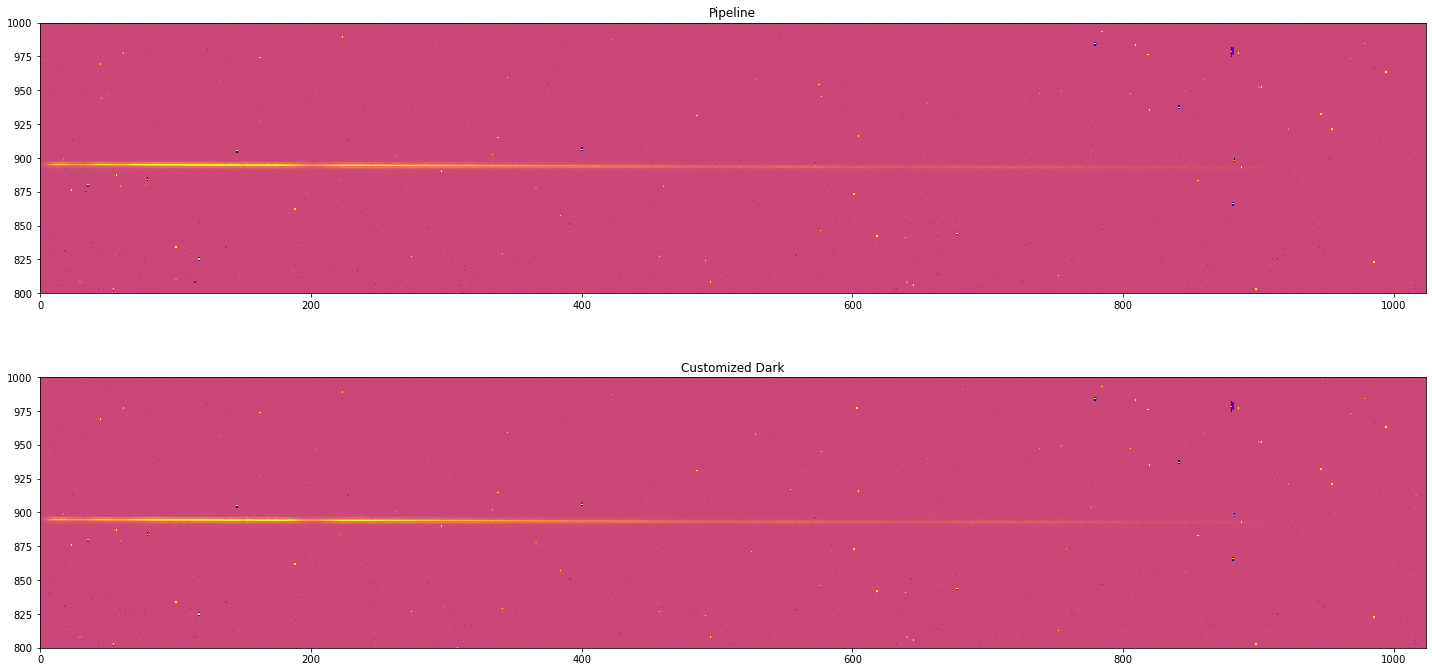

In [12]:
# Plot the calibrated _crj images
# The plot above is the defalt _crj image from the pipline
# the plot below is calibrated with our customized dark file
plt.subplot(2,1,1)
with fits.open(crj) as hdu:
    ex1 = hdu[1].data
    plt.imshow(ex1,vmin=-1000,vmax=1000)
    plt.ylim(800,1000)
    plt.title("Pipeline")
plt.subplot(2,1,2)
with fits.open("./new_dark/oeax05040_crj.fits") as hdu:
    ex1 = hdu[1].data
    plt.imshow(ex1,vmin=-1000,vmax=1000)
    plt.ylim(800,1000)
    plt.title("Customized Dark")
plt.tight_layout()

Visualize the flux difference in the _sx1 spectra:

Text(0, 0.5, 'Flux Difference [ergs/s/cm$^2$/Å]')

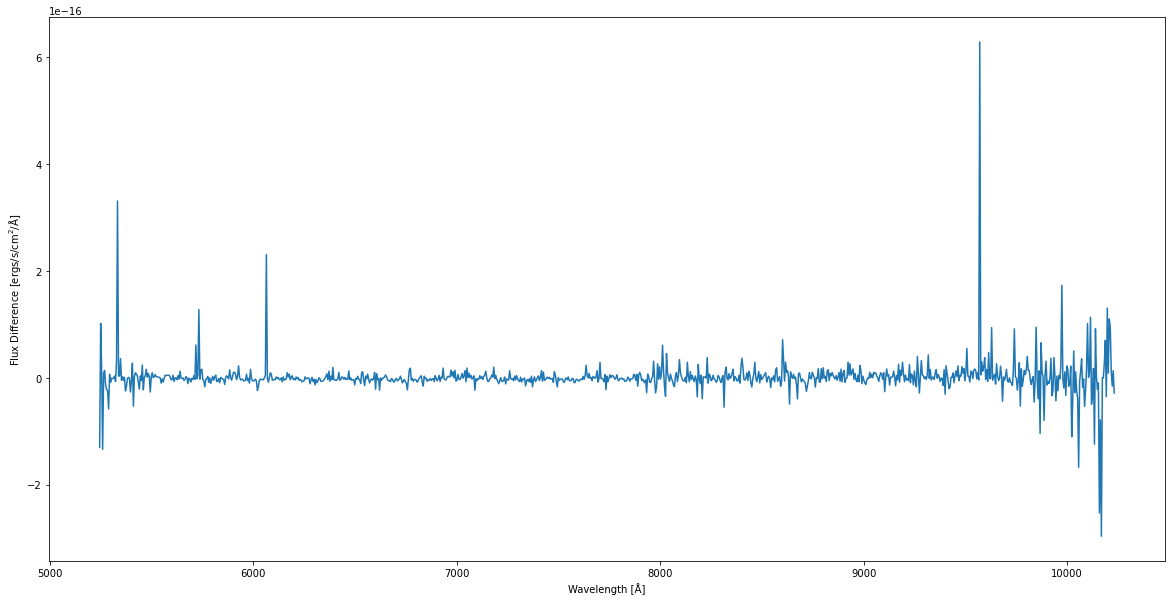

In [13]:
# get the spectrum of the default pipline _sx1 data
pip = Table.read("./mastDownload/HST/oeax05040/oeax05040_sx1.fits",1)
wl,pip_flux = pip[0]["WAVELENGTH","FLUX"]
# get the flux of the customized new_dark _sx1 data
cus = Table.read("./new_dark/oeax05040_sx1.fits",1)
cus_flux = cus[0]["FLUX"]
# plot the spectra difference
plt.plot(wl,cus_flux-pip_flux)
plt.xlabel('Wavelength [' + chr(197) +']')
plt.ylabel("Flux Difference [ergs/s/cm$^2$/" + chr(197) +"]")


---
## About this Notebook <a class="tocSkip">
**Author:** [Keyi Ding](kding@stsci.edu)

**Updated On:** 2022-09-26


> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*
## Citations <a class="tocSkip">

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 